# Cálculo de la saturación de oxígeno a partir de los datos crudos del sensor

## 1. Corrección de las señales (eliminar la luz ambiental)
En el firmware del pulsioxímetro, generalmente se resta la luz ambiental a la señal principal, es decir:

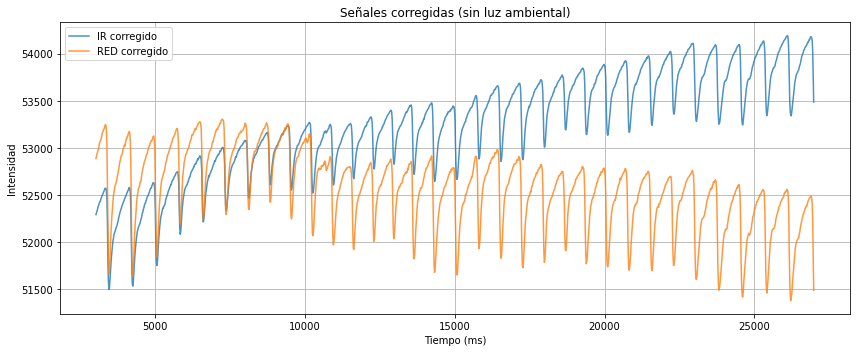

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Ruta del archivo CSV
file_path = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2\raw_data_95_77_2.csv"

# Cargar datos
data = pd.read_csv(file_path, delimiter=';')

# Recorte de los primeros y últimos 3 segundos
t_min = data["Tiempo (ms)"].min()
t_max = data["Tiempo (ms)"].max()
data = data[(data["Tiempo (ms)"] >= t_min + 3000) & (data["Tiempo (ms)"] <= t_max - 3000)].reset_index(drop=True)

# Corrección de luz ambiental
data['IR_corr'] = data['IR'] - data['AMB_IR']
data['RED_corr'] = data['RED'] - data['AMB_RED']

# Visualización de las señales corregidas
plt.figure(figsize=(12, 5))
plt.plot(data['Tiempo (ms)'], data['IR_corr'], label='IR corregido', alpha=0.8)
plt.plot(data['Tiempo (ms)'], data['RED_corr'], label='RED corregido', alpha=0.8)
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad")
plt.title("Señales corregidas (sin luz ambiental)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Filtrado de señales

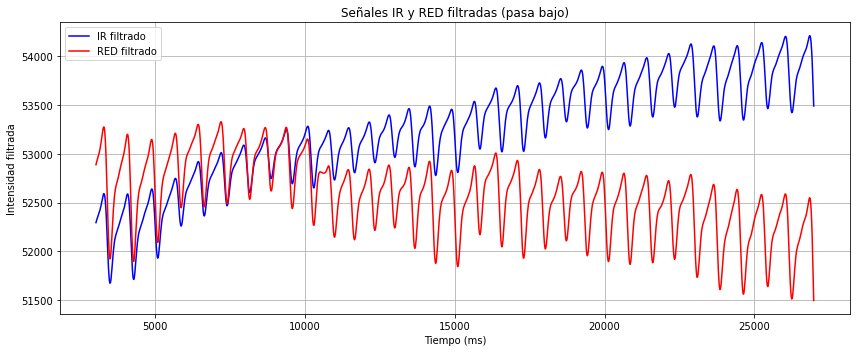

In [2]:
from scipy.signal import butter, filtfilt

# Frecuencia de muestreo estimada (en Hz)
# Asumimos que el muestreo es cada 16 ms (según el firmware)
fs = 1000 / 16  # ≈ 62.5 Hz

# Crear filtro Butterworth paso bajo (orden 3, frecuencia de corte 4 Hz)
def butter_lowpass_filter(signal, cutoff=4, fs=fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered = filtfilt(b, a, signal)
    return filtered

# Aplicar filtro a las señales corregidas
data['IR_filt'] = butter_lowpass_filter(data['IR_corr'])
data['RED_filt'] = butter_lowpass_filter(data['RED_corr'])

# Visualizar las señales filtradas
plt.figure(figsize=(12, 5))
plt.plot(data['Tiempo (ms)'], data['IR_filt'], label='IR filtrado', color='blue')
plt.plot(data['Tiempo (ms)'], data['RED_filt'], label='RED filtrado', color='red')
plt.xlabel("Tiempo (ms)")
plt.ylabel("Intensidad filtrada")
plt.title("Señales IR y RED filtradas (paso bajo)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Cálculo del ratio R y estimación de SpO₂:
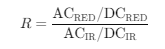
Y a partir de ahí, aplicar la fórmula empírica que usa el firmware, por ejemplo: SpO₂=104−17⋅R

In [4]:
import numpy as np

# Componente DC: media
dc_ir = np.mean(data['IR_filt'])
dc_red = np.mean(data['RED_filt'])

# Componente AC: desviación típica (std)
ac_ir = np.std(data['IR_filt'])
ac_red = np.std(data['RED_filt'])

# Ratio R
R = (ac_red / dc_red) / (ac_ir / dc_ir)

# Fórmula empírica (basada en el firmware)
spo2 = 104 - 17 * R

# === Mostrar resultado ===
print(f"SpO₂ estimada: {spo2:.2f}%")

SpO₂ estimada: 91.89%



📄 Procesando archivo: raw_data_91_91.csv
🩺 SpO₂ estimada: 98.02%


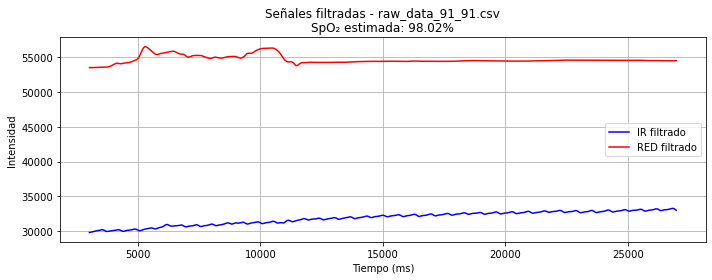


📄 Procesando archivo: raw_data_92_76.csv
🩺 SpO₂ estimada: -92.39%


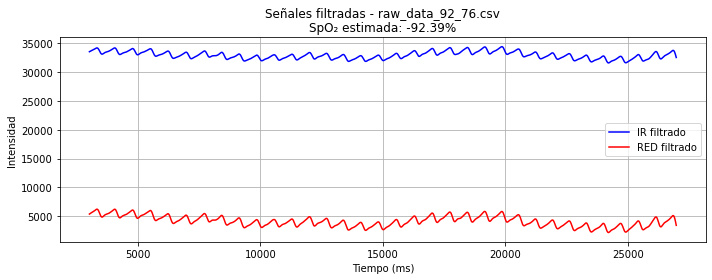


📄 Procesando archivo: raw_data_93_100.csv
🩺 SpO₂ estimada: 104.39%


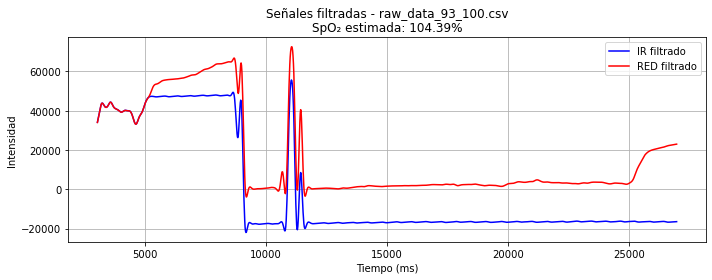


📄 Procesando archivo: raw_data_95_77_2.csv
🩺 SpO₂ estimada: 91.89%


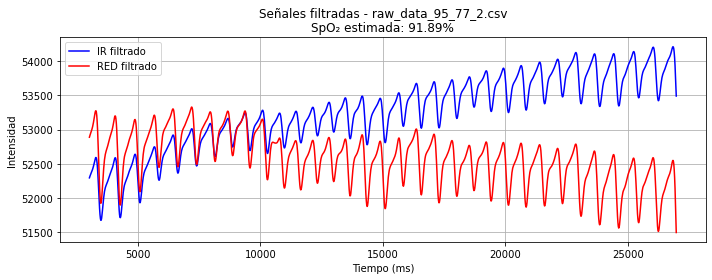


📄 Procesando archivo: raw_data_95_80.csv
🩺 SpO₂ estimada: 63.36%


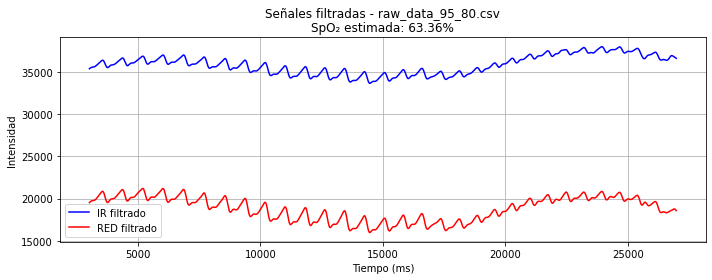


📄 Procesando archivo: raw_data_95_81_papa.csv
🩺 SpO₂ estimada: 93.84%


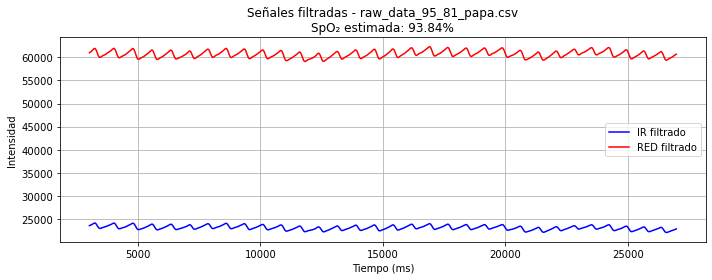


📄 Procesando archivo: raw_data_95_99.csv
🩺 SpO₂ estimada: 72.73%


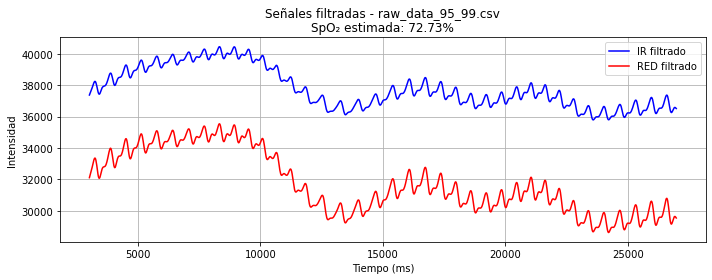


📄 Procesando archivo: raw_data_96_106.csv
🩺 SpO₂ estimada: 91.53%


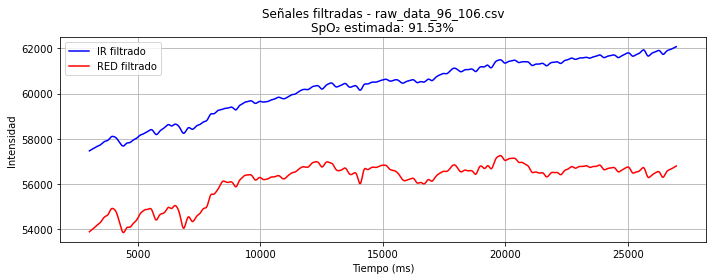


📄 Procesando archivo: raw_data_96_69.csv
🩺 SpO₂ estimada: 89.05%


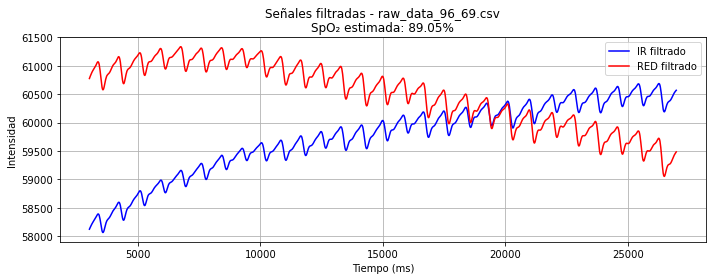


📄 Procesando archivo: raw_data_97_119.csv
🩺 SpO₂ estimada: 90.93%


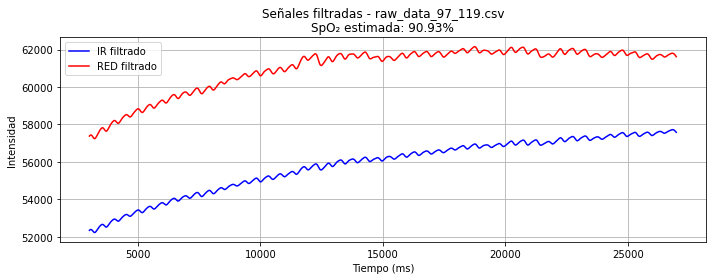


📄 Procesando archivo: raw_data_97_95.csv
🩺 SpO₂ estimada: -938.22%


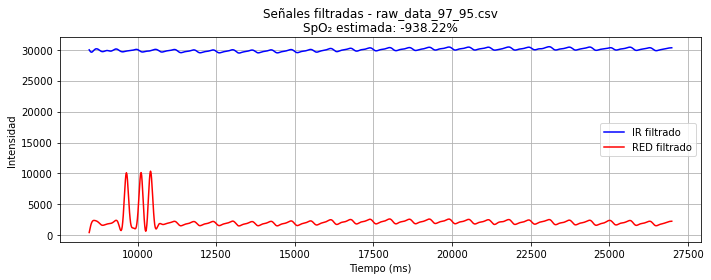


📄 Procesando archivo: raw_data_98_81.csv
🩺 SpO₂ estimada: 97.67%


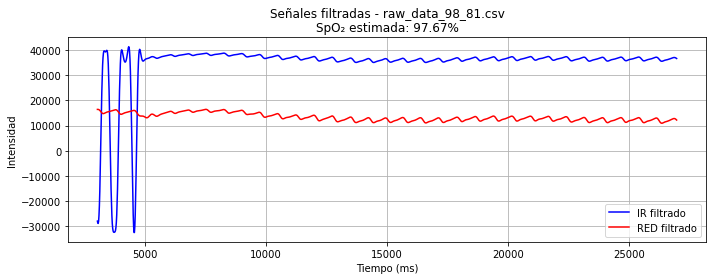


📄 Procesando archivo: raw_data_98_86.csv
🩺 SpO₂ estimada: 533.70%


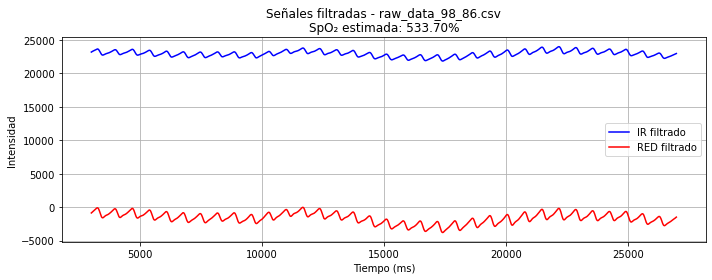


📄 Procesando archivo: raw_data_98_91.csv
🩺 SpO₂ estimada: 89.10%


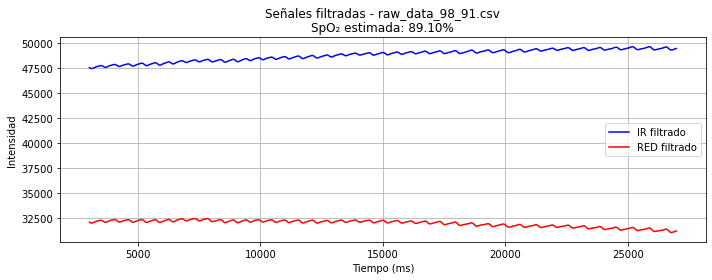


📄 Procesando archivo: raw_data_99_75.csv
🩺 SpO₂ estimada: 62.88%


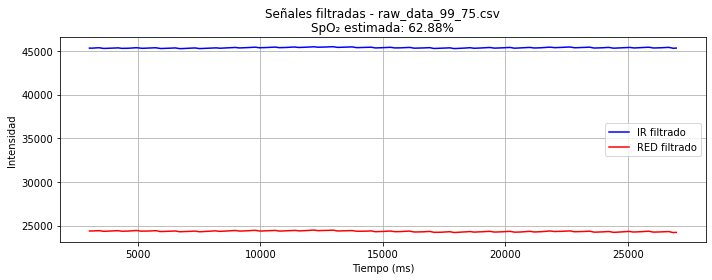


📄 Procesando archivo: raw_data_99_91.csv
🩺 SpO₂ estimada: 76.07%


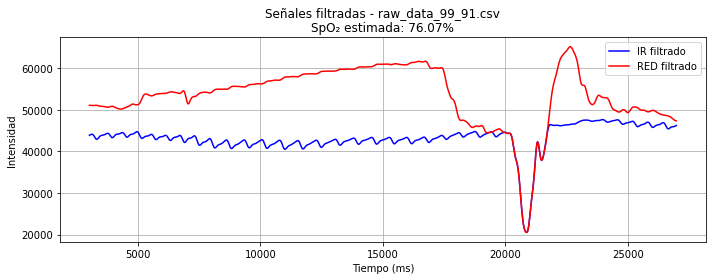

In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

# === CONFIGURACIÓN GENERAL ===
carpeta = r"C:\Users\Elena\Desktop\GitHub\TFG-Elena-Ruiz\Datos\Datos crudos\save_log2"
fs = 1000 / 16  # ≈ 62.5 Hz

# === Función de filtrado pasa bajo Butterworth ===
def butter_lowpass_filter(signal, cutoff=4, fs=fs, order=3):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal)

# === Procesar todos los archivos CSV en la carpeta ===
for archivo in os.listdir(carpeta):
    if archivo.endswith(".csv"):
        ruta_completa = os.path.join(carpeta, archivo)
        print(f"\n Procesando archivo: {archivo}")
        
        # Cargar datos
        data = pd.read_csv(ruta_completa, delimiter=';')

        # Recorte de extremos (3 s)
        t_min = data["Tiempo (ms)"].min()
        t_max = data["Tiempo (ms)"].max()
        data = data[(data["Tiempo (ms)"] >= t_min + 3000) & (data["Tiempo (ms)"] <= t_max - 3000)].reset_index(drop=True)

        # Corrección luz ambiental
        data['IR_corr'] = data['IR'] - data['AMB_IR']
        data['RED_corr'] = data['RED'] - data['AMB_RED']

        # Filtro pasa bajo
        data['IR_filt'] = butter_lowpass_filter(data['IR_corr'])
        data['RED_filt'] = butter_lowpass_filter(data['RED_corr'])

        # Cálculo de AC y DC
        dc_ir = np.mean(data['IR_filt'])
        dc_red = np.mean(data['RED_filt'])
        ac_ir = np.std(data['IR_filt'])
        ac_red = np.std(data['RED_filt'])

        # Ratio y SpO2
        R = (ac_red / dc_red) / (ac_ir / dc_ir)
        spo2 = 104 - 17 * R

        # Mostrar resultado
        print(f" SpO₂ estimada: {spo2:.2f}%")

        # Mostrar gráfica
        plt.figure(figsize=(10, 4))
        plt.plot(data['Tiempo (ms)'], data['IR_filt'], label='IR filtrado', color='blue')
        plt.plot(data['Tiempo (ms)'], data['RED_filt'], label='RED filtrado', color='red')
        plt.title(f"Señales filtradas - {archivo}\nSpO₂ estimada: {spo2:.2f}%")
        plt.xlabel("Tiempo (ms)")
        plt.ylabel("Intensidad")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


# Explicación

El pulsioxímetro mide la saturación de oxígeno en sangre (SpO₂), es decir, qué porcentaje de hemoglobina en la sangre está cargada con oxígeno.

La hemoglobina tiene dos formas relevantes:

- HbO₂ (oxihemoglobina): transporta oxígeno.

- Hb (desoxihemoglobina): no transporta oxígeno.

Ambas absorben la luz de manera distinta:

- La **Luz roja (~660 nm)** es más absorbida por la **Hb (desoxihemoglobina)**
- La **Luz infrarroja (IR) (~940 nm)** es más absorbida por la **HbO₂ (oxihemoglobina)**

El sensor emite luz en dos longitudes de onda: roja y IR. Un fotodiodo mide cuánto se absorbe de cada una. Esa absorción varía con cada latido, porque los vasos se expanden con sangre oxigenada y luego se vacían.

Por eso las señales de IR y RED son pulsátiles: los picos representan los latidos, y su variación es proporcional a la cantidad de sangre y oxígeno.

### ¿Cómo se estima SpO₂?
#### 1. Corrección de luz ambiental
Primero restamos la luz "ambiente" (valores de AMB_IR y AMB_RED) para quedarnos con la señal real de absorción por el dedo del bebé (o en mi caso, la mía para validar):\
IR_corr = IR - AMB_IR\
RED_corr = RED - AMB_RED


#### 2. Filtrado paso bajo
La señal tiene ruido (del sensor, del movimiento, interferencias). Aunque previamente hemos quitado los primeros y últimos 3 segundos, aplicamos un **filtro paso bajo** para dejar solo la parte pulsátil (≤ 4 Hz, porque un corazón normal late entre 0.5 y 3 Hz).

Esto suaviza la señal y deja solo la parte fisiológica útil:\
IR_filt = butter_lowpass_filter(IR_corr)\
RED_filt = butter_lowpass_filter(RED_corr)


#### 3. Separación en componentes AC y DC
Cada señal tiene dos componentes:

**DC (Direct Current)** → La media: representa la absorción constante (tejido, piel, hueso).

**AC (Alternating Current)** → La oscilación: representa los latidos y el paso de sangre oxigenada.

El cociente AC/DC elimina variaciones por piel gruesa, presión del sensor, etc.
 
Por eso calculamos:

dc_ir = np.mean(IR_filt)\
ac_ir = np.std(IR_filt)\

dc_red = np.mean(RED_filt)\
ac_red = np.std(RED_filt)\

#### 4. Cálculo del ratio R

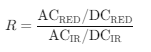

Este ratio compara cómo se comporta la luz roja (más absorbida por sangre sin oxígeno) respecto a la IR (más absorbida por sangre con oxígeno).

Si R es alto → hay más Hb → baja SpO₂

Si R es bajo → hay más HbO₂ → alta SpO₂

####  5. Estimación empírica de SpO₂
El firmware original usa una fórmula basada en calibración con personas sanas (no es una ley física, sino una aproximación experimental válida para valores típicos (de 70% a 100%).

SpO₂=104−17⋅R


#### CSV → Eliminar extremos → Corregir luz ambiental → Filtrar señales → Separar AC/DC → Calcular ratio R → Estimar SpO₂ → Visualizar/guardar